# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 
import zipfile

from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2 as cv
from glob import glob
import pandas as pd
import requests

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [4]:
DIR = '/kaggle/input/diabetic-retinopathy-detection'

with zipfile.ZipFile(f'{DIR}/trainLabels.csv.zip', 'r') as zip_ref:
    with zip_ref.open('trainLabels.csv') as csv_file:
        trainLabels_df = pd.read_csv(csv_file, index_col=0).reset_index()

trainLabels_df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [5]:
print("Total:", len(trainLabels_df))
print("Stage 0:", len(trainLabels_df[trainLabels_df["level"]==0]))
print("Stage 1:", len(trainLabels_df[trainLabels_df["level"]==1]))
print("Stage 2:", len(trainLabels_df[trainLabels_df["level"]==2]))
print("Stage 3:", len(trainLabels_df[trainLabels_df["level"]==3]))
print("Stage 4:", len(trainLabels_df[trainLabels_df["level"]==4]))

Total: 35126
Stage 0: 25810
Stage 1: 2443
Stage 2: 5292
Stage 3: 873
Stage 4: 708


In [6]:
stage_0_df = trainLabels_df[trainLabels_df["level"]==0].sample(700)
stage_1_df = trainLabels_df[trainLabels_df["level"]==1].sample(700)
stage_2_df = trainLabels_df[trainLabels_df["level"]==2].sample(700)
stage_3_df = trainLabels_df[trainLabels_df["level"]==3].sample(700)
stage_4_df = trainLabels_df[trainLabels_df["level"]==4].sample(700)

stage_0_train, stage_0_valid = train_test_split(stage_0_df, test_size=0.2, random_state=42)
stage_1_train, stage_1_valid = train_test_split(stage_1_df, test_size=0.2, random_state=42)
stage_2_train, stage_2_valid = train_test_split(stage_2_df, test_size=0.2, random_state=42)
stage_3_train, stage_3_valid = train_test_split(stage_3_df, test_size=0.2, random_state=42)
stage_4_train, stage_4_valid = train_test_split(stage_4_df, test_size=0.2, random_state=42)

train_df = pd.concat([stage_0_train, stage_1_train, stage_2_train, stage_3_train, stage_4_train]).sample(960)
valid_df = pd.concat([stage_0_valid, stage_1_valid, stage_2_valid, stage_3_valid, stage_4_valid]).sample(320)

In [7]:
class EyeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406),
                       (0.229, 0.224, 0.225))
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['image']
        filepath = f"https://diabetic-retinopathy-images.s3.ap-southeast-1.amazonaws.com/images/{image_name}.jpeg" 
        response = requests.get(filepath)
        print(response.status_code, image_name, end="\r")
        if response.status_code != 200:
            pass
        image_data = response.content
        nparr = np.frombuffer(image_data, np.uint8)
        image = cv.imdecode(nparr, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, thresholded = cv.threshold(image, 0, 255, cv.THRESH_OTSU)
        x, y, w, h = cv.boundingRect(thresholded)
        cropped_image = cv.cvtColor(image[y:y+h, x:x+w], cv.COLOR_GRAY2RGB)
        cropped_image = Image.fromarray(cropped_image)
        target = self.df.iloc[idx]['level']
        
        return cropped_image, target
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        targets = targets.squeeze().long()
        targets = targets.to(device)
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        ).to(device)
        return imgs, targets

In [8]:
train_ds = EyeDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      collate_fn=train_ds.collate_fn)

valid_ds = EyeDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=64,
                      collate_fn=valid_ds.collate_fn)

In [9]:
class EyeClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features

        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 5),
            nn.LogSoftmax(dim=1)
        )
        

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
classifier = EyeClassifier(pretrained=True)
_ = summary(classifier, torch.ones(1,3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 5]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 28, 28] 

In [11]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = torch.tensor(outputs.cpu().detach().tolist())
    targets = targets.cpu().detach().tolist()
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().detach().tolist()
    fake_recall_score = recall_score(targets, preds,
                               zero_division=0,
                               average='macro')
    
    return loss.cpu().detach().item(), fake_recall_score

In [12]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    
    outputs = torch.tensor(outputs.cpu().detach().tolist())
    targets = targets.cpu().detach().tolist()
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().detach().tolist()
    fake_recall_score = recall_score(targets, preds,
                               zero_division=0,
                               average='macro')
    
    return loss.cpu().detach().item(), fake_recall_score

In [13]:
classifier = EyeClassifier(pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5,
                                      gamma=0.25)
best_recall_score = 0
n_epochs = 10
xticks = list(i+1 for i in range(n_epochs))

In [14]:
mem = {
    'train_loss': [],
    'train_recall_score': [],
    'valid_loss': [],
    'valid_recall_score': []
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recall_scores = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall_score = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recall_scores.append(train_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall score:', "%.3f" % train_recall_score, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall_score'].append(np.mean(train_recall_scores))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recall_scores = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall_score = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recall_scores.append(valid_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall score:', "%.3f" % valid_recall_score, 
            end='\r'
        )
    
    cur_recall_score = np.mean(valid_recall_scores)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall_score'].append(cur_recall_score)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall score:', "%.3f" % mem['train_recall_score'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall score:', "%.3f" % mem['valid_recall_score'][-1],
    )
    
    if best_recall_score < cur_recall_score:
        best_recall_score = cur_recall_score
        torch.save(classifier.state_dict(), './saved_model/diabetic_state_dict.pth')
        torch.save(classifier, './saved_model/diabetic_model.pth')
        
    scheduler.step()

Training:   0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 	train loss: 1.839 	train recall score: 0.277 	valid loss: 7.501 	valid recall score: 0.243
epoch: 2 	train loss: 1.514 	train recall score: 0.339 	valid loss: 86.138 	valid recall score: 0.218
epoch: 3 	train loss: 1.418 	train recall score: 0.382 	valid loss: 2.442 	valid recall score: 0.282
epoch: 4 	train loss: 1.317 	train recall score: 0.443 	valid loss: 1.836 	valid recall score: 0.315
epoch: 5 	train loss: 1.285 	train recall score: 0.456 	valid loss: 1.491 	valid recall score: 0.356
epoch: 6 	train loss: 1.094 	train recall score: 0.534 	valid loss: 1.357 	valid recall score: 0.436
epoch: 7 	train loss: 1.005 	train recall score: 0.569 	valid loss: 1.429 	valid recall score: 0.391
epoch: 8 	train loss: 0.856 	train recall score: 0.647 	valid loss: 1.624 	valid recall score: 0.385
epoch: 9 	train loss: 0.740 	train recall score: 0.698 	valid loss: 1.671 	valid recall score: 0.364
epoch: 10 	train loss: 0.563 	train recall score: 0.788 	valid loss: 1.874 	valid recall s

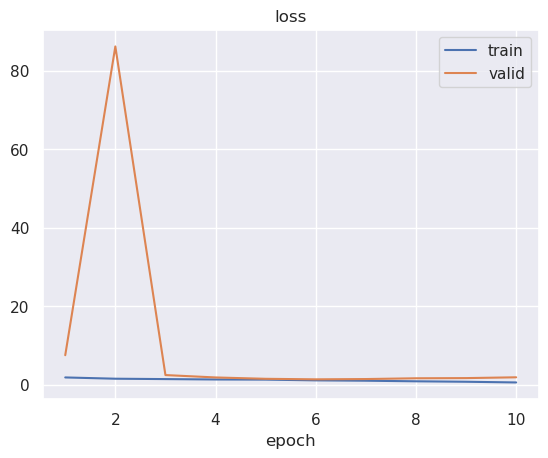

In [15]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

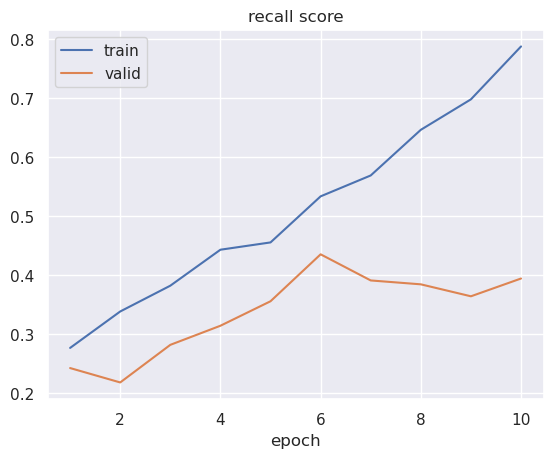

In [16]:
plt.plot(xticks, mem['train_recall_score'])
plt.plot(xticks, mem['valid_recall_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()